# Matemática para Ciencia de los Datos
### Trabajo práctico 2 (TP2)

María Auxiliadora Mora
Instituto Tecnológico de Costa Rica, 

Medio de entrega: Por medio del TEC-Digital.

Entregables: Un archivo zip con los resultados de los ejercicios. 

Modo de trabajo: en grupo máximo de dos personas.


---

Resumen: En el presente trabajo práctico se realizarán ejercicios para repasar aspectos básicos del algebra lineal, cálculo matricial y preprocesamiento de datos. 

---


**Pregunta 1 (30 puntos)**

**Exploración, visualización de datos y cálculo matricial.**

1) Para el ejercicio se va a utilizar el conjunto de datos "Used Cars Price Prediction" https://www.kaggle.com/avikasliwal/used-cars-price-prediction. Utilice las columnas numéricas para el ejercicio. Verifique que los campos numéricos no contenga caracteres.

2) Cargue los datos utilizando un dataframe de Pandas. 

3) Despliegue la lista de columnas y elimine las columnas con datos no numéricos. 

4) Despliegue datos estadísticos del dataframe como la media, desviación estándar, entre otros.

5) Explore y visualice la relación de los datos utilizando gráficos de dispersión.

6) Seleccione una columna y elimine datos atípicos.

7) Despliegue un mapa de calor de los datos.

8) Convierta los datos a una matriz de Pytorch y utilice tensores de Pytorch para realizar el resto del ejercicio.

9) Se desea expresar los datos de la forma $A\vec{x}=b$ donde $b$, el objetivo, es un vector con los datos de la última columna (asumiendo que queremos predecir el precio medio de las autos usados en el conjunto de datos, este corresponde a la columna price). El resto de las columnas representarán la matriz $A$. 

- Una vez divididos los datos, proponga valores de $\vec{x}$ que tengan sentido de forma intuitiva para realizar la multiplicación matriz-vector. El resultado ideal de esta multiplicación es tener una predicción de los valores de los autos. El objetivo de este ejercicio es que los estudiantes se familiaricen con los datos. Es útil en este tipo de tareas validar el conocimiento de dominio con lo que eventualmente generará un modelo. Revise el ejercicio práctico visto en clase. 
- Ordenar el conjunto de datos original de mayor o menor (por precio del auto) y agregar una columna de 1 hasta $m$, donde $m$ es el total de filas, que reflejen un escalafón de autos más o menos costosos. Repetir el proceso con los pesos $\vec{x}$ de ejemplo y comparar, visualmente, qué tan cercano es el escalafón real al de predicción. Posteriormente, genere una métrica para comparar los escalafones.


In [1]:
#Library to be used in second question
#pip install opencv-python

In [2]:
# Bibliotecas a utilizar
###############################################################################
import torch 
import math 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import re
import cv2
import torch.nn as nn
# Gráficas estadísticas
import seaborn as sns


In [3]:
#Cargue los datos utilizando un dataframe de Pandas.
df = pd.read_csv('datasets/train-data.csv')
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
# select numerical columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
df_numeric.head()

,Unnamed: 0,Year,Kilometers_Driven,Seats,Price
0,0,2010,72000,5.0,1.75
1,1,2015,41000,5.0,12.50
2,2,2011,46000,5.0,4.50
3,3,2012,87000,7.0,6.00
4,4,2013,40670,5.0,17.74


In [5]:
# select non-numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
df_non_numeric.head()

,Name,Location,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,NaN
2,Honda Jazz V,Chennai,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,NaN


In [6]:
#Despliegue la lista de columnas y elimine las columnas con datos no numéricos.
to_drop = ['Unnamed: 0',  
           'Name',
           'Location',
           'Fuel_Type',
           'Transmission',
           'Owner_Type']

df.drop(to_drop, inplace=True, axis=1)
df.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Price
0,2010,72000,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,2015,41000,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2011,46000,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,2012,87000,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,2013,40670,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [7]:
#remove alpha characters from numeric data
df.replace(r'[a-zA-Z%/]', '', regex=True, inplace=True)
df.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Price
0,2010,72000,26.6,998,58.16,5.0,NaN,1.75
1,2015,41000,19.67,1582,126.2,5.0,NaN,12.50
2,2011,46000,18.2,1199,88.7,5.0,8.61,4.50
3,2012,87000,20.77,1248,88.76,7.0,NaN,6.00
4,2013,40670,15.2,1968,140.8,5.0,NaN,17.74


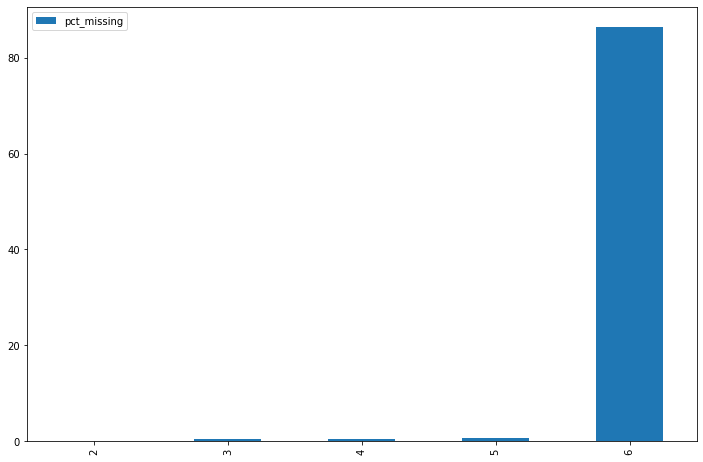

In [8]:
# % of values missing in each column
values_list = list()
cols_list = list()
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())*100
    cols_list.append(col)
    values_list.append(pct_missing)
pct_missing_df = pd.DataFrame()
pct_missing_df['col'] = cols_list
pct_missing_df['pct_missing'] = values_list

pct_missing_df.loc[pct_missing_df.pct_missing > 0].plot(kind='bar', figsize=(12,8))
plt.show()

In [9]:
#empty rows as nan
df = df.replace(r'^\s*$', np.nan, regex=True)

#drop rows with na if the % is low
less_missing_values_cols_list = list(pct_missing_df.loc[(pct_missing_df.pct_missing < 0.9) & (pct_missing_df.pct_missing > 0), 'col'].values)
df.dropna(subset=less_missing_values_cols_list, inplace=True)

df.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Price
0,2010,72000,26.6,998,58.16,5.0,NaN,1.75
1,2015,41000,19.67,1582,126.2,5.0,NaN,12.50
2,2011,46000,18.2,1199,88.7,5.0,8.61,4.50
3,2012,87000,20.77,1248,88.76,7.0,NaN,6.00
4,2013,40670,15.2,1968,140.8,5.0,NaN,17.74


In [10]:
# dropping columns with more than 40% null values, in this case new_price
_40_pct_missing_cols_list = list(pct_missing_df.loc[pct_missing_df.pct_missing > 40, 'col'].values)
df.drop(columns=_40_pct_missing_cols_list, inplace=True)
df.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
0,2010,72000,26.6,998,58.16,5.0,1.75
1,2015,41000,19.67,1582,126.2,5.0,12.50
2,2011,46000,18.2,1199,88.7,5.0,4.50
3,2012,87000,20.77,1248,88.76,7.0,6.00
4,2013,40670,15.2,1968,140.8,5.0,17.74


In [11]:
df.dtypes

Year                   int64
Kilometers_Driven      int64
Mileage               object
Engine                object
Power                 object
Seats                float64
Price                float64
dtype: object

In [12]:
#transform datatypes in number columns
df[['Mileage', 'Engine','Power']] = df[['Mileage', 'Engine','Power']].astype('float64')
df.dtypes

Year                   int64
Kilometers_Driven      int64
Mileage              float64
Engine               float64
Power                float64
Seats                float64
Price                float64
dtype: object

In [13]:
#Despliegue datos estadísticos del dataframe como la media, desviación estándar, entre otros.
# Estadísticas de los datos 
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe(include = 'all')

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,5872.000000,5.872000e+03,5872.000000,5872.000000,5872.000000,5872.000000,5872.000000
mean,2013.477691,5.831700e+04,18.277839,1625.745572,113.276894,5.283719,9.603919
std,3.164568,9.216941e+04,4.365657,601.641783,53.881892,0.805081,11.249453
min,1998.000000,1.710000e+02,0.000000,624.000000,34.200000,2.000000,0.440000
25%,2012.000000,3.342250e+04,15.260000,1198.000000,75.000000,5.000000,3.517500
50%,2014.000000,5.260900e+04,18.200000,1495.500000,97.700000,5.000000,5.750000
75%,2016.000000,7.240275e+04,21.100000,1991.000000,138.100000,5.000000,10.000000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,10.000000,160.000000


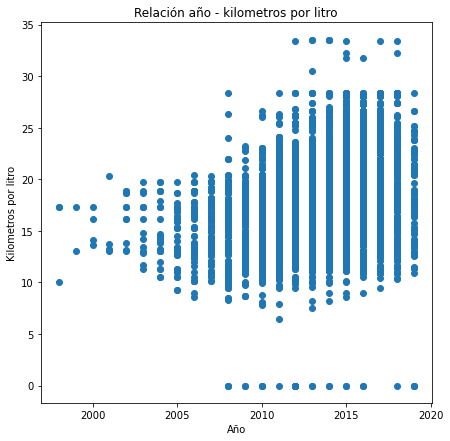

In [14]:

def plot_data(df, col_x, col_y, label_x, label_y, val_title):
    # Imprime gráfica de dispersión. 
    #Parameters: 
    #df: pandas data frame
    #col_x,y: column axis
    #label_x,y: column labels
    #val_title: titulo de grafico
    
    plt.figure(figsize=(7,7))
    plt.scatter(x=df[col_x],y=df[col_y])
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(val_title)
    plt.show()
    

#Explore y visualice la relación de los datos utilizando gráficos de dispersión.
plot_data(df,'Year', 'Mileage', 'Año','Kilometros por litro',
          'Relación año - kilometros por litro')  



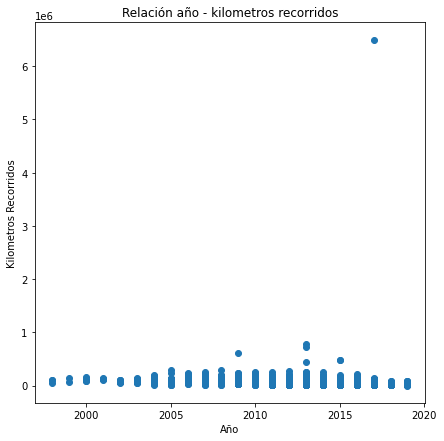

In [15]:
plot_data(df,'Year', 'Kilometers_Driven', 'Año','Kilometros Recorridos',
         'Relación año - kilometros recorridos')  

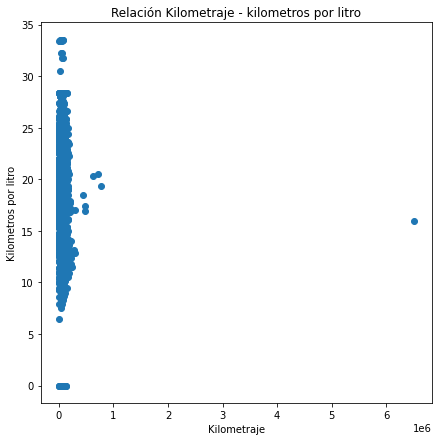

In [16]:
plot_data(df,'Kilometers_Driven', 'Mileage', 'Kilometraje','Kilometros por litro',
         'Relación Kilometraje - kilometros por litro') 

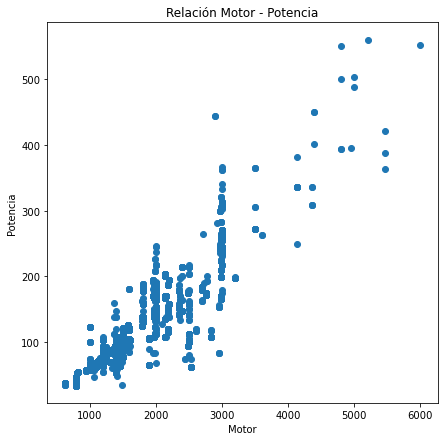

In [17]:
plot_data(df,'Engine', 'Power', 'Motor','Potencia',
         'Relación Motor - Potencia') 

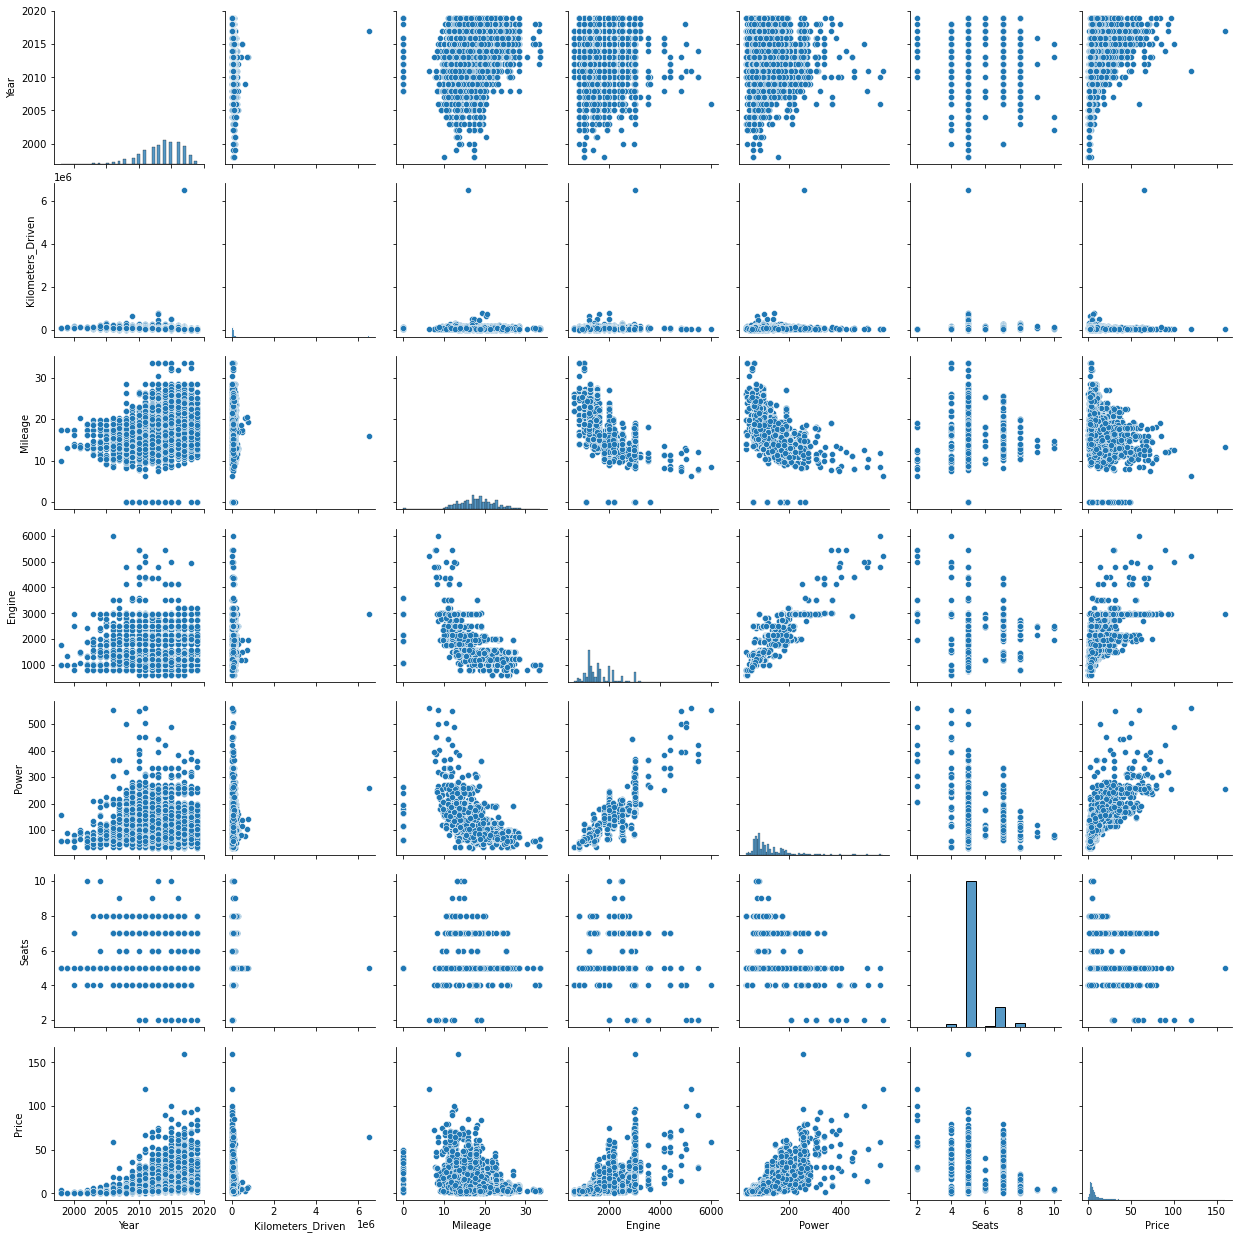

In [18]:
# La siguiente gráfica presenta la correlación entre pares de variables. 

# En la diagonal se ven los histogramas de cada variable

sns.pairplot(df);

In [19]:
#Seleccione una columna y elimine datos atípicos.
df = df.loc[df.Kilometers_Driven < 250000]
df.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,5857.000000,5857.000000,5857.000000,5857.000000,5857.000000,5857.000000,5857.000000
mean,2013.481987,56388.782141,18.284263,1624.687212,113.266927,5.281885,9.603305
std,3.163313,32614.955063,4.366934,601.405132,53.904212,0.802745,11.238093
min,1998.000000,171.000000,0.000000,624.000000,34.200000,2.000000,0.440000
25%,2012.000000,33284.000000,15.290000,1198.000000,75.000000,5.000000,3.510000
50%,2014.000000,52400.000000,18.250000,1495.000000,97.600000,5.000000,5.750000
75%,2016.000000,72007.000000,21.100000,1985.000000,138.100000,5.000000,10.000000
max,2019.000000,248000.000000,33.540000,5998.000000,560.000000,10.000000,160.000000


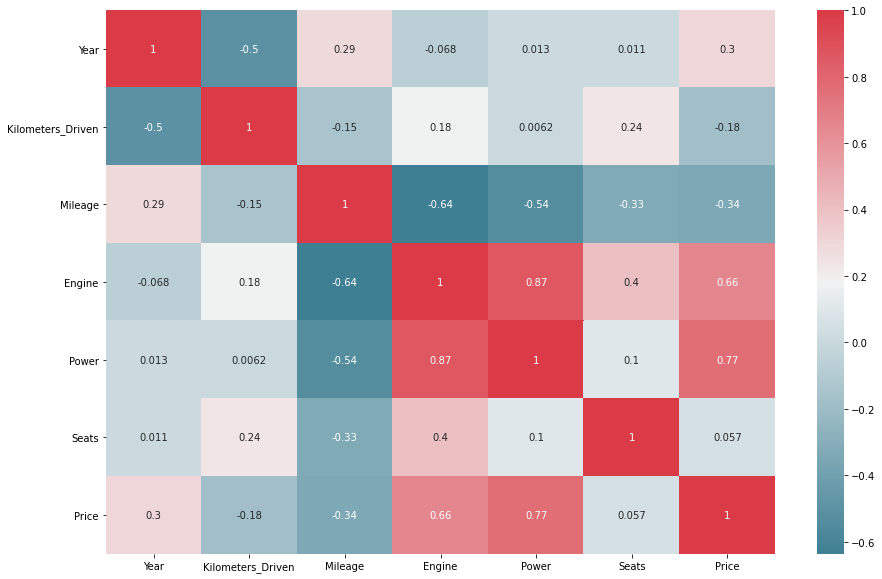

In [20]:
#Despliegue un mapa de calor de los datos.
def correlation_heatmap(df1):
    _,ax=plt.subplots(figsize=(15,10))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(df.corr(),annot=True,cmap=colormap)
    
correlation_heatmap(df)


In [21]:
#Convierta los datos a una matriz de Pytorch y utilice tensores de Pytorch para realizar el resto del ejercicio.

# Selección de las columnas a utilizar
features=['Year', 'Kilometers_Driven', 'Mileage', 'Engine',
       'Power', 'Seats' ]

print(features)

x_features = df[features]
y_targets = df['Price']

print(x_features)
print(y_targets)

# Convertir a tensor de Pytorch
print(x_features.columns)
A=torch.tensor(x_features.values) 

['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats']
      Year  Kilometers_Driven  Mileage  Engine   Power  Seats
0     2010              72000    26.60   998.0   58.16    5.0
1     2015              41000    19.67  1582.0  126.20    5.0
2     2011              46000    18.20  1199.0   88.70    5.0
3     2012              87000    20.77  1248.0   88.76    7.0
4     2013              40670    15.20  1968.0  140.80    5.0
...    ...                ...      ...     ...     ...    ...
6014  2014              27365    28.40  1248.0   74.00    5.0
6015  2015             100000    24.40  1120.0   71.00    5.0
6016  2012              55000    14.00  2498.0  112.00    8.0
6017  2013              46000    18.90   998.0   67.10    5.0
6018  2011              47000    25.44   936.0   57.60    5.0

[5857 rows x 6 columns]
0        1.75
1       12.50
2        4.50
3        6.00
4       17.74
        ...  
6014     4.75
6015     4.00
6016     2.90
6017     2.65
6018     2.50
Name: Pr

In [22]:
# Escalar los datos 
A = np.array( A )
scaler = MinMaxScaler()     #de la biblioteca Scikit-learn
scaler.fit(A) 
A = scaler.transform(A)

#Cantidad de muestras
cantidad_muestras = len(A)

# Se convierte A a un tensor de Pytorch.
A = torch.tensor( A )

print("Primeros 5 cinco registros de A")
print(A[0:5])
print(A[0:5,:])

print("Primera columna de A")
print(A[:,0])

print("Dimensiones de A = ", A.shape)

# Ver dimensiones
total_columnas = A.shape[1] # columnas
total_filas = A.shape[0] # filas
print("Total filas ", total_filas)
print("Total columnas ", total_columnas)

Primeros 5 cinco registros de A
tensor([[0.5714, 0.2898, 0.7931, 0.0696, 0.0456, 0.3750],
        [0.8095, 0.1647, 0.5865, 0.1783, 0.1750, 0.3750],
        [0.6190, 0.1849, 0.5426, 0.1070, 0.1037, 0.3750],
        [0.6667, 0.3504, 0.6193, 0.1161, 0.1038, 0.6250],
        [0.7143, 0.1634, 0.4532, 0.2501, 0.2027, 0.3750]], dtype=torch.float64)
tensor([[0.5714, 0.2898, 0.7931, 0.0696, 0.0456, 0.3750],
        [0.8095, 0.1647, 0.5865, 0.1783, 0.1750, 0.3750],
        [0.6190, 0.1849, 0.5426, 0.1070, 0.1037, 0.3750],
        [0.6667, 0.3504, 0.6193, 0.1161, 0.1038, 0.6250],
        [0.7143, 0.1634, 0.4532, 0.2501, 0.2027, 0.3750]], dtype=torch.float64)
Primera columna de A
tensor([0.5714, 0.8095, 0.6190,  ..., 0.6667, 0.7143, 0.6190],
       dtype=torch.float64)
Dimensiones de A =  torch.Size([5857, 6])
Total filas  5857
Total columnas  6


In [23]:
# b  el target, es un vector con los datos de price

b=torch.tensor(y_targets.values) 
print("Algunas filas de b")
print( b[0:3])

print("Tamaño de b=", b.size())

Algunas filas de b
tensor([ 1.7500, 12.5000,  4.5000], dtype=torch.float64)
Tamaño de b= torch.Size([5857])


In [24]:
#Proponga valores de 𝑥⃗ que tengan sentido de forma intuitiva para luego realizar la multiplicación 
#de la matriz y cada vector.
#Year,Kilometers_Driven,Mileage,Engine,Power,Seats
x_mas_engine_power = torch.tensor([ 0, 0, 0, 1, 1, 0],dtype=torch.double)
x_mas_kilometraje_engine = torch.tensor([0, 1, 0, 1, 0, 0], dtype=torch.double)

In [25]:
# Multiplicación de la matriz por cada uno de los vectores "x"
b_engine_power = torch.matmul(A, x_mas_engine_power)
b_kilometraje = torch.matmul(A, x_mas_kilometraje_engine)



In [26]:
# Usando la pseudo inversa
# en x_calculado se encontrará los valores calculados para x
print("Tamaño de b:", b.size())
print("Tamaño de A:", A.size())

# pseudo inversa de A por b
x_calculado =  torch.matmul(torch.pinverse(A), b)

print("x calculado=", x_calculado.shape)

#Con el x obtenido se calcula la predicción 
b_nuevo =  torch.matmul(A, x_calculado)

print("Predicción de b =", b_nuevo[0:3])

Tamaño de b: torch.Size([5857])
Tamaño de A: torch.Size([5857, 6])
x calculado= torch.Size([6])
Predicción de b = tensor([-3.7704, 12.9954,  4.6844], dtype=torch.float64)


In [27]:
# reordenando de los vectores en forma de columna para luego concatenarlos
ranking = np.array(range(1, total_filas+1))
ranking =  np.reshape(ranking, (total_filas, 1))

nb = np.reshape(b, (total_filas, 1))
nb_kilometraje = np.reshape(b_kilometraje, (total_filas, 1))
nb_engine = np.reshape(b_engine_power, (total_filas, 1))
nb_nuevo = np.reshape(b_nuevo, (total_filas, 1))

# Matriz de predicciones
A_predicciones= np.concatenate( (nb, nb_kilometraje, nb_engine, nb_nuevo),axis=1)

#Matriz de predicciones escalada
scaler = MinMaxScaler()
scaler.fit(A_predicciones)
A_predicciones = scaler.transform(A_predicciones)

# Matriz de predicciones con el ranking
A_predicciones= np.concatenate( (A_predicciones, ranking),axis=1)

# Cada matriz contienen la matriz de predicciones ordenada por 
# cada columna de b descendentemente
ordenado_b = np.array(sorted(A_predicciones, key=lambda a_entry: a_entry[0],reverse=True) )
ordenado_b_kilometraje = np.array(sorted(A_predicciones, key=lambda a_entry: a_entry[1],reverse=True) )
ordenado_b_engine = np.array(sorted(A_predicciones, key=lambda a_entry: a_entry[2],reverse=True) )
ordenado_b_nuevo = np.array(sorted(A_predicciones, key=lambda a_entry: a_entry[3],reverse=True) )

print("tamaño de ordenado_b", ordenado_b.shape)
print("tamaño de ordenado_b_kilometraje", ordenado_b_kilometraje.shape)

# Ver los primeros de cada uno de los vectores.
tcuantosPrimeros = 5
print("b")
print(ordenado_b[0:tcuantosPrimeros,-1])
print(ordenado_b[0:tcuantosPrimeros,0])
print("b_engine")
print(ordenado_b_engine[0:tcuantosPrimeros,-1])
print(ordenado_b_engine[0:tcuantosPrimeros,1])
print("b_kilometraje")
print(ordenado_b_kilometraje[0:tcuantosPrimeros,-1])
print(ordenado_b_kilometraje[0:tcuantosPrimeros,2])
print("b_nuevo")
print(ordenado_b_nuevo[0:tcuantosPrimeros,-1])
print(ordenado_b_nuevo[0:tcuantosPrimeros,3])

tamaño de ordenado_b (5857, 5)
tamaño de ordenado_b_kilometraje (5857, 5)
b
[3961. 5627. 5761. 1461. 1921.]
[1.         0.7493106  0.62396591 0.60560291 0.58429431]
b_engine
[5372. 5627. 2042. 4946. 5761.]
[0.8415455  0.61613744 0.64541333 0.69629284 0.59331936]
b_kilometraje
[4658. 1068. 2900. 2278. 4374.]
[0.35165915 0.23970419 0.23970419 0.23252236 0.35165915]
b_nuevo
[5627. 5761. 5372. 2042. 4946.]
[1.         0.9207199  0.915818   0.87865076 0.85879269]


In [28]:
print(ranking)

[[   1]
 [   2]
 [   3]
 ...
 [5855]
 [5856]
 [5857]]


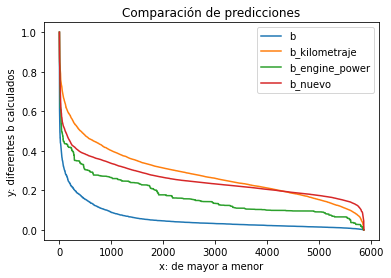

In [29]:
# Graficación de los resultados

import matplotlib.pyplot as plt

# Limpia la figura 
plt.clf()

# Figura en el eje x el secuencial o ranking y en el eje y la predicción ordenada
# b
x1 = ranking
y1 = ordenado_b[:,0]
plt.plot(x1, y1, label = "b")

# b_kilometraje
x2 = ranking
y2 = ordenado_b_kilometraje[:,1].flatten()
plt.plot(x2, y2, label = "b_kilometraje")

# b_anno
x3 = ranking
y3 = ordenado_b_engine[:,2].flatten()
plt.plot(x3, y3, label = "b_engine_power")

# b_nuevo
x4 = ranking
y4 = ordenado_b_nuevo[:,3].flatten()
plt.plot(x4, y4, label = "b_nuevo")

plt.xlabel('x: de mayor a menor')
# Set the y axis label of the current axis.
plt.ylabel('y: diferentes b calculados')
# Set a title of the current axes.
plt.title('Comparación de predicciones')
# show a legend on the plot
plt.legend()

# Display a figure.
plt.show()

In [30]:
print('b, b_kilometraje')
sq_real = np.power((np.array(b_kilometraje)-np.array(b)), 2)
#sq_kilometraje = np.power(np.array(b_kilometraje), 2)
print('Root Mean Square Deviation')
print(math.sqrt(np.sum(sq_real)/b.shape[0]))

b, b_kilometraje
Root Mean Square Deviation
14.479243058758774


In [31]:
print('b, b_engine_power')
sq_real = np.power(np.array(b_engine_power)-np.array(b), 2)
print('Root Mean Square Deviation')
print(math.sqrt(np.sum(sq_real)/b.shape[0]))

b, b_engine_power
Root Mean Square Deviation
14.44820354206539


In [32]:
print("La mejor aproximación")
print('b, b_nuevo')
sq_real = np.power(np.array(b_nuevo)-np.array(b), 2)
print('Root Mean Square Deviation')
print(math.sqrt(np.sum(sq_real)/b.shape[0]))

La mejor aproximación
b, b_nuevo
Root Mean Square Deviation
6.469139934348136


**Pregunta 2 (10 puntos)**

**Convolución** 

a) (5 puntos) Programe manualmente usando tensores de Pytorch, pero sin utilizar funiones predefinidas en la biblioteca, la función convolucion2D que reciba una imagen, un kernel de cualquier tamaño, el tamaño del padding a aplicar y devuelva la imagen resultante de la convolución.

b) (2 puntos) Cargue una imagen de prueba en escala de grises o convierta alguna imagen a escala de grises (adjunte el archivo de imagen de prueba con el archivo del trabajo en un zip).

c) (3 puntos) Investigue qué son los filtros de desenfoque gaussiano y aplique al menos dos kernels de este tipo con diferentes tamaño en su imagen utilizando la función convolucion2D que desarrolló en el punto 1.

In [33]:

def convolucion2d(image, kernel, padding=1):
    #calcule convolution of an image
    #parameters: image: image as torch,
    #kernel: filter torch
    #padding: padding value
    #return: the convolve image
    
    m = nn.ZeroPad2d(padding)# effectively zero padding
    
    image = m(image) 
    
    kernel_height, kernel_width = kernel.shape
    padded_height, padded_width = image.shape

    output_height = (padded_height - kernel_height) 
    output_width = (padded_width - kernel_width)

    new_image = torch.zeros((output_height, output_width))
    
    for y in range(0, output_height):
        for x in range(0, output_width):
            new_image[y][x] = torch.sum(image[y:y + kernel_height, x:x + kernel_width] * kernel)
    return new_image




In [34]:
def processImage(image):
  #load an image in grayscale
  #Parameters: the torch matrix image
  #Return: the image
  image = cv2.imread(image) 
  image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY) 
  return image

image = processImage('sample_data/golden.jpg')

#image as a tensor
A = torch.from_numpy(image)

#kernel as a tensor
kernel = torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

# Convolve and Save Output
output = convolucion2d(A, kernel)

cv2.imwrite('sample_data/2DConvolved.jpg', output.numpy())

True

In [ ]:
#Gauss Filter 1

image = processImage('sample_data/golden.jpg')

#image as a tensor
A = torch.from_numpy(image)

kernel = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
kernel = kernel / torch.sum(kernel)

# Convolve and Save Output
output = convolucion2d(A, kernel, padding=1)
cv2.imwrite('sample_data/G1.jpg', output.numpy())

In [ ]:
#Gauss Filter 2

image = processImage('sample_data/golden.jpg')

#image as a tensor
A = torch.from_numpy(image)

kernel = torch.tensor( [ [1,4,7,4,1], [4,16,26,16,4], [7,26,41,26,7],[4,16,26,16,4],[1,4,7,4,1]] )
kernel = kernel / torch.sum(kernel)

# Convolve and Save Output
output = convolucion2d(A, kernel, padding=2)
cv2.imwrite('sample_data/G2.jpg', output.numpy())